<a href="https://colab.research.google.com/github/amcheyre-nw/DL_Object_detection/blob/main/Faster_RCNN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Download TorchVision repo to use some files from references/detection
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git


In [9]:
# Install libraries
! pip install albumentations==0.4.6

In [10]:
# Python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
import json

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations (not working this)
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

## BBD100K Dataset

In [11]:
# Import database
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [12]:
# defining the files directory and testing directory
files_dir = '/content/drive/MyDrive/BDD100K/sample_train'
test_dir = '/content/drive/MyDrive/BDD100K/sample_val'

In [30]:
class SelfDrivingCarDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(self.files_dir)) if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        # classes bike -> bicycle, motor -> motorcycle, pedestrian -> person (check in COCO)
        self.classes = [_,'person', 'rider', 'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle',
                        'traffic light', 'traffic sign']

    def __getitem__(self, idx):
        cv2.setNumThreads(0)
        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)

        scale_percent = 20 # percent of original size
        self.width = int(img.shape[1] * scale_percent / 100)
        self.height = int(img.shape[0] * scale_percent / 100)
        dim = (self.width, self.height)

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = cv2.resize(img_rgb, dim, cv2.INTER_AREA)
        img_res /= 255.0
        
        # annotation file
        if self.files_dir == files_dir:
          annot_filename = 'bdd100k_labels_images_train.json'
          annot_file_path = '/content/drive/MyDrive/BDD100K/labels_FRCNN/bdd100k_labels_images_train.json'
        else:
          annot_filename = 'bdd100k_labels_images_val.json'
          annot_file_path = '/content/drive/MyDrive/BDD100K/labels_FRCNN/bdd100k_labels_images_val.json'

        json_file = open(annot_file_path)
        train_data = json.load(json_file)
        
        boxes = []
        labels = []
        images = []
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # get information from the every image
        for image in train_data:
          # check if image json is in image files
          if image['name'] == img_name:
            images.append(image['name'])
            for i in range(len(image['labels'])):
              label = image['labels'][i]['category']
              if label in self.classes:
                labels.append(self.classes.index(label))
                
                # bounding box
                xmin = image['labels'][i]['box2d']['x1']
                xmax = image['labels'][i]['box2d']['x2']
                
                ymin = image['labels'][i]['box2d']['y1']
                ymax = image['labels'][i]['box2d']['y2']
                      
                xmin_corr = (xmin/wt)*self.width
                xmax_corr = (xmax/wt)*self.width
                ymin_corr = (ymin/ht)*self.height
                ymax_corr = (ymax/ht)*self.height
                
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)


# check dataset
dataset = SelfDrivingCarDataset(files_dir, 1280, 720)
print('length of dataset = ', len(dataset), '\n')

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[121]
print(img.shape, '\n', target)

length of dataset =  210 

(144, 256, 3) 
 {'boxes': tensor([[156.0307,  55.7722, 162.5626,  59.3351],
        [169.3915,  31.1289, 183.6431,  50.1309],
        [155.6388,  63.4788, 158.6079,  65.2602],
        [152.9666,  63.4788, 155.6388,  65.5571],
        [150.5914,  63.7757, 153.5604,  67.0417],
        [148.2161,  63.4788, 151.7790,  66.7448],
        [146.7316,  63.7757, 149.1068,  66.7448],
        [143.4656,  63.1819, 147.3254,  67.3386],
        [ 50.9901,  61.5192,  67.6169,  67.4573],
        [ 65.5386,  45.7831,  88.4004,  77.8491],
        [ 74.1489,  38.6573, 147.7819, 113.4780],
        [  0.0000,  54.6903,  51.5839, 107.5398]]), 'labels': tensor([10, 10,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3]), 'area': tensor([2.3273e+01, 2.7081e+02, 5.2892e+00, 5.5537e+00, 9.6969e+00, 1.1636e+01,
        7.0523e+00, 1.6044e+01, 9.8732e+01, 7.3309e+02, 5.5093e+03, 2.7262e+03]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([121])}


## Visualization of bounding boxes

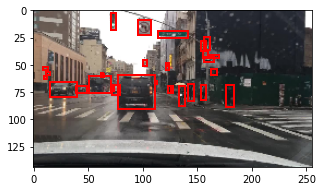

In [32]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)

    for box in (target['boxes']):
      
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[200]
plot_img_bbox(img, target)

# Load the pre-trained model Fast RCNN

In [33]:
# Pre-trained model
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    #num_ftrs = model.fc.in_features

    #model_conv.f = nn.Sequential(
    #       nn.Linear(25088 , 512),
    #       nn.BatchNorm1d(512),
    #       nn.Dropout(0.2),
    #       nn.Linear(512 , 256),
    #       nn.Linear(256 , 3))

    for param in model.parameters():
      param.requires_grad = False 
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

# Data Augmentation

In [34]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

In [35]:
# use our dataset and defined transformations
dataset = SelfDrivingCarDataset(files_dir, 1280, 720, transforms= get_transform(train=True))
dataset_test = SelfDrivingCarDataset(files_dir, 1280, 720, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=16, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=16, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)


# Training the model

In [36]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 11

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [37]:
# training for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [0/7]  eta: 1:04:00  lr: 0.000838  loss: 4.4296 (4.4296)  loss_classifier: 2.4366 (2.4366)  loss_box_reg: 0.8219 (0.8219)  loss_objectness: 0.9179 (0.9179)  loss_rpn_box_reg: 0.2533 (0.2533)  time: 548.5974  data: 546.1652  max mem: 10424


KeyboardInterrupt: ignored

# Decoding predictions

In [38]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Test the model

In [41]:
# pick one image from the test set
img, target = dataset_test[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  100
real #boxes:  13


EXPECTED OUTPUT


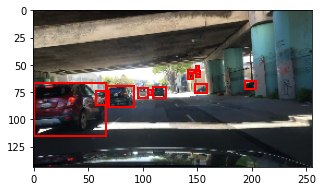

In [42]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

In [43]:
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
#plot_img_bbox(torch_to_pil(img), nms_prediction)

NMS APPLIED MODEL OUTPUT


EXPECTED OUTPUT



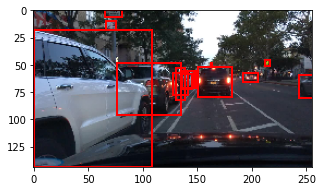

MODEL OUTPUT



TypeError: ignored

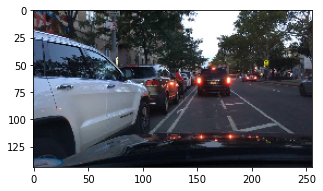

In [44]:
test_dataset = SelfDrivingCarDataset(test_dir, 1280, 720, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[10]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)